In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('ignore')

ITEM 1 - IMPORTAÇÃO DOS DADOS

In [3]:
# importando CSV dos dados
PATH = 'C:/Users/Bruno Adalberto/Desktop/Aulas Pós/Primeiro Módulo/Trabalho Final/winequalityN.csv'
data = pd.read_csv(PATH)
data.columns = data.columns.str.lower().str.replace(' ', '_')

data.head() 

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Verificando informações dos dados

In [4]:
print(data['type'].value_counts())
data.info()
data.isna().sum()


type
white    4898
red      1599
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   ph                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
ph                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

ITEM 2 - Ela possui uma variável denominada "quality", uma nota de 0 a 10 que denota a qualidade do vinho. Crie uma nova variável, chamada "opinion" que será uma variável categórica igual à 0, quando quality for menor e igual à 5. O valor será 1, caso contrário. Desconsidere a variável quality para o restante da análise.

In [5]:
#Adiciona coluna binária opinion
data['opinion'] = np.where(data['quality'] <= 5, 1, 0)
data.drop(columns=['quality'], inplace=True) 

In [6]:

#tratar os dados nulos.
#Abordagem, vou verificar o valor minimo e máximo da coluna para verificar se há muita variação dos valores, 
# se não houver, usarei a media, se não, usarei a mediana para tratar os nulos.

def fillna_with_mean_or_median(column, data):
    min_val = data[column].min()
    max_val = data[column].max()
    mean = data[column].mean()
    median = data[column].median()

    intervalo = max_val - min_val
    result = data[column]
    if intervalo > 2 * mean: 
        data[column] = result.fillna(median)
    else:
        data[column] = result.fillna(mean)
 
fillna_with_mean_or_median('fixed_acidity', data)  
fillna_with_mean_or_median('volatile_acidity', data)  
fillna_with_mean_or_median('citric_acid', data)  
fillna_with_mean_or_median('residual_sugar', data)  
fillna_with_mean_or_median('chlorides', data)  
fillna_with_mean_or_median('ph', data)
fillna_with_mean_or_median('sulphates', data)

#verificar informações duplicadas removendo as duplicadas preserando a última linha
num_duplicatas = data.duplicated().sum()
 

data.isna().sum()
data_red = data.query("type == 'red'")
data = data.query("type == 'white'") 
 

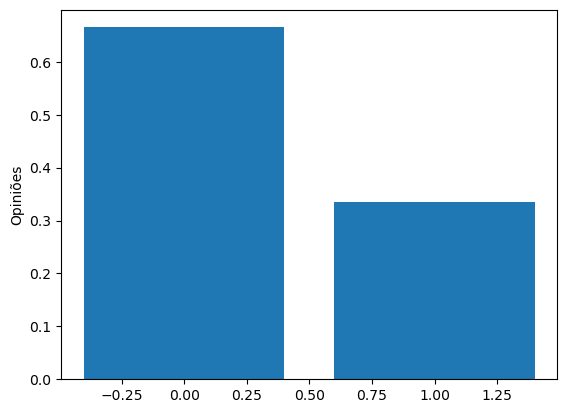

In [7]:
proportions = data['opinion'].value_counts(normalize=True)

plt.bar(x=proportions.index, height=proportions.values)
plt.ylabel('Opiniões')
plt.show()

ITEM 3 - Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?

type = Define o tipo do vinho, Tinto e Branco. ( CATEGÓRICA )
fixed_acidity = Acidez fixa ácidos não voláteis do vinho ( CONTÍNUA)
volatile_acidity = Acidez Volátil Representa os ácidos que evaporam facilmente  ( CONTÍNUA )
citric_acid = Ácido Cítrico  ( CONTÍNUA )      
residual_sugar = Açúcar Residual Açúcares que não foram fermentados pelo fermento ( CONTÍNUA )      
chlorides = Cloretos Representam o teor de sal no vinho ( CONTÍNUA )
free_sulfur_dioxide = Dióxido de Enxofre Livre - Usado como conservante ( DISCRETA )
total_sulfur_dioxide = Dióxido de Enxofre Total - indicador importante de qualidade e estabilidade do vinho. ( DISCRETA )
density = Densidade Está relacionada ao teor alcoólico e ao açúcar residual ( CONTÍNUA )
ph = Mede a acidez geral do vinho ( CONTÍNUA )
Sulphates = SULFATOS Contribuem para a estabilidade microbiológica e preservação do vinho. ( CONTÍNUA )
alcohol = Teor alcólico ( CONTÍNUA )
quality = Qualidade do vinho ( DISCRETA )
opinion = Variavel target ( CATEGÓRICA )

In [8]:
print(data.dtypes)

# Ver estatísticas das variáveis 
data.describe()

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                 float64
opinion                   int32
dtype: object


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,opinion
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.856121,0.278269,0.334241,6.391864,0.045779,35.308085,138.360657,0.994027,3.188246,0.489843,10.514267,0.334831
std,0.843244,0.100740,0.120961,5.071702,0.021845,17.007137,42.498065,0.002991,0.150910,0.114124,1.230621,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


ITEM 4 - (A) Descreva as etapas necessárias para criar um modelo de classificação eficiente.

1 -  Leitura dos dados
2 -  Avaliação dos tipos de dados, variáveis categoricas, discretas e contínuas
3 -  Verificação dos dados nulos e como resolver de acordo com o que o negócio espera.
4 -  Elimar a coluna de test e definir a target
5 -  Verificar o balanceamento das classes
6 -  Análise de separabilidade linear ( visual ) usando pairplot 
7 -  Separar features em X e Y, sendo X as variaveis usadas para os calculos do modelo e Y a variavel target
8 -  Aplicar o stratify para manter a proporção das classes
9 -  Separação Treino e teste usando train_test_split e stratify
10 - Analise de proporções dos dados para ver manteve a mesma proporção do dataset
11 - Criar um modelo baseline de acordo com o que fizer mais sentido
12 - Avaliar métricas do Baseline
13 - Treinar o modelo escolhido ( ou vários )
14 - Configurar o amostrador para as validações cruzadas
15 - Ajustar os Hyperparametros 
16 - Usar o buscador (GridSearch) para detectar as melhores combinações de hyperparametros
17 - Analisar as métricas do melhor modelo, usando confusion matrix, curva roc e os indicadores ( precision, recall f1 e accuracy ) de acordo com o que fizer mais sentido pro negócio.

ITEM 4 - (B)

Treine um modelo de regressão logística usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:

In [9]:
# Definindo variáveis numéricas e categóricas 
data.head()
num = [col for col in data.columns if col not in ['type', 'opinion']] 
target = 'opinion'

x = data.drop(columns=[target])
y = data[[target]]

x_red = data_red.drop(columns=[target])
y_red = data_red[[target]]
 

In [10]:

# separação treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=2)

print(y_train.value_counts(normalize=True))

opinion
0          0.665111
1          0.334889
Name: proportion, dtype: float64


In [11]:
# criando um pipeline de processamento 
preprocessor = ColumnTransformer([ # Aplicando o Ohe para a categoria type
    ('num_continuas', RobustScaler(), num), # aplicando a escala robusta para as demais variaveis  
])

# criando os pipelines
reglog = Pipeline([
    ('transformer', preprocessor),
    ('model', LogisticRegression(solver='saga'))
])

dt_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', DecisionTreeClassifier(random_state=2))
])

svm_pipeline = Pipeline([
    ('transformer', preprocessor),  # Reutilizando o mesmo pré-processador
    ('model', SVC(probability=True, random_state=2))  # Ativar probabilidade para avaliação de performance
])

# configurar o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

In [31]:
# função para exibir os resultados do modelo
def show_results_models(model: GridSearchCV, x_train, x_test, y_train, y_test, exec_train = True):
    print('Best params ==>', model.best_params_)
    print('Best score:', model.best_score_)
 
    # Análise do desempenho nos dados de treino e teste
    if exec_train :
        yhat_predicted_train = model.best_estimator_.predict(x_train)
        print('Desempenho - Base de Treino')
        print(classification_report(y_train, yhat_predicted_train))
        # Avaliação no treino
        acuracia_train = accuracy_score(y_train, yhat_predicted_train)
        precisao_train = precision_score(y_train, yhat_predicted_train, average='weighted')
        recall_train = recall_score(y_train, yhat_predicted_train, average='weighted')
        f1_train = f1_score(y_train, yhat_predicted_train, average='weighted')

        accuracy_mean_train = np.mean(model.cv_results_['mean_test_accuracy'])
        accuracy_std_train = np.std(model.cv_results_['mean_test_accuracy'])

        precision_mean_train = np.mean(model.cv_results_['mean_test_precision'])
        precision_std_train = np.std(model.cv_results_['mean_test_precision'])

        recall_mean_train = np.mean(model.cv_results_['mean_test_recall'])
        recall_std_train = np.std(model.cv_results_['mean_test_recall'])

        f1_mean_train = np.mean(model.cv_results_['mean_test_f1'])
        f1_std_train = np.std(model.cv_results_['mean_test_f1'])

        print("\nMédias das métricas nos dados de TREINO:")
        print(f"Acurácia: {acuracia_train:.4f}")
        print(f"Precisão: {precisao_train:.4f}")
        print(f"Recall: {recall_train:.4f}")
        print(f"F1-Score: {f1_train:.4f}")

        print("\nMédias das métricas de todos os modelos do GRIDSearch TREINO:")
        print(f"Acurácia (media): {accuracy_mean_train:.4f}")
        print(f"Acurácia (Desvio): {accuracy_std_train:.4f}")

        print(f"Precisão(Media): {precision_mean_train:.4f}")
        print(f"Precisão(Desvio): {precision_std_train:.4f}")

        print(f"Recall(Media): {recall_mean_train:.4f}")
        print(f"Recall(Desvio): {recall_std_train:.4f}" )

        print(f"F1-Score(Media): {f1_mean_train:.4f}")
        print(f"F1-Score(Desvio): {f1_std_train:.4f}")


    yhat_predicted_test = model.best_estimator_.predict(x_test)
    print('Desempenho - Base de Teste')
    print(classification_report(y_test, yhat_predicted_test)) 

    # Avaliação no teste
    acuracia_test = accuracy_score(y_test, yhat_predicted_test)
    precisao_test = precision_score(y_test, yhat_predicted_test, average='weighted')
    recall_test = recall_score(y_test, yhat_predicted_test, average='weighted')
    f1_test = f1_score(y_test, yhat_predicted_test, average='weighted')

    print('==> ' + str(model.cv_results_))

    accuracy_mean_test = np.mean(model.cv_results_['mean_test_accuracy'])
    accuracy_std_test = np.std(model.cv_results_['mean_test_accuracy'])

    precision_mean_test = np.mean(model.cv_results_['mean_test_precision'])
    precision_std_test = np.std(model.cv_results_['mean_test_precision'])

    recall_mean_test = np.mean(model.cv_results_['mean_test_recall'])
    recall_std_test = np.std(model.cv_results_['mean_test_recall'])

    f1_mean_test = np.mean(model.cv_results_['mean_test_f1'])
    f1_std_test = np.std(model.cv_results_['mean_test_f1'])
 
    # Exibir resultados médios
    print("\nMédias das métricas nos dados de TESTE:")
    print(f"Acurácia: {acuracia_test:.4f}")
    print(f"Precisão: {precisao_test:.4f}")
    print(f"Recall: {recall_test:.4f}")
    print(f"F1-Score: {f1_test:.4f}")

    print("\nMédias das métricas de todos os modelos do GRIDSearch TREINO:")
    print(f"Acurácia (media): {accuracy_mean_test:.4f}")
    print(f"Acurácia (Desvio): {accuracy_std_test:.4f}")

    print(f"Precisão(Media): {precision_mean_test:.4f}")
    print(f"Precisão(Desvio): {precision_std_test:.4f}")

    print(f"Recall(Media): {recall_mean_test:.4f}")
    print(f"Recall(Desvio): {recall_std_test:.4f}" )

    print(f"F1-Score(Media): {f1_mean_test:.4f}")
    print(f"F1-Score(Desvio): {f1_std_test:.4f}")



In [33]:

#TREINAMENTO DO MODELO DE REGRESSÃO LOGISTICA
params_grid_reglog = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None]
}

# configurar o buscador
search_reglog = GridSearchCV(
    estimator=reglog,
    param_grid=params_grid_reglog,
    scoring='accuracy',
    cv=splitter,
    refit=True,
    error_score=0,
    n_jobs=-1
)

search_reglog.fit(x_train, y_train) 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num_continuas',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcohol'])])),
                                       ('model',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__class_weight': ['balanced', None],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='accuracy')

In [34]:
#ITEM 4 - (B)    
#i. a média e desvio da acurácia dos modelos obtidos; 
#ii. a média e desvio da precisão dos modelos obtidos;
#iii. a média e desvio da recall dos modelos obtidos;
#iv. a média e desvio do f1-score dos modelos obtidos.
show_results_models(search_reglog, x_train, x_test, y_train, y_test, False)

Best params ==> {'model__C': 1, 'model__class_weight': None, 'model__l1_ratio': 0.25, 'model__penalty': 'l1'}
Best score: 0.7534934274461664
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       978
           1       0.67      0.48      0.56       492

    accuracy                           0.74      1470
   macro avg       0.72      0.68      0.69      1470
weighted avg       0.74      0.74      0.73      1470

==> {'mean_fit_time': array([0.00812571, 0.0112813 , 0.0125401 , 0.04871268, 0.00911355,
       0.01427567, 0.01199009, 0.05402975, 0.00883367, 0.0117228 ,
       0.00894144, 0.06097391, 0.00953381, 0.0145766 , 0.01508939,
       0.06000123, 0.00817695, 0.01479483, 0.01088216, 0.05480604,
       0.01007252, 0.01477909, 0.00850353, 0.05500069, 0.01328921,
       0.0161129 , 0.02390203, 0.05579977, 0.01580186, 0.01643538,
       0.01690154, 0.05719745, 0.01400757, 0.01333976, 0.01561441,
       0.05576

KeyError: 'mean_test_accuracy'

ITEM 4 - (C) 

Treine um modelo de árvores de decisão usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos. 

In [15]:
#TREINAMENTO DO MODELO DE ARVORE DE DECISÃO
params_grid_dt = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None]
}



# configurar o buscador
search_dt_categ = GridSearchCV(
    estimator=dt_categ,
    param_grid=params_grid_dt,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0, 
    n_jobs=-1
)

search_dt_categ.fit(x_train, y_train) 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num_continuas',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcohol'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced', None],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(2, 11)},
             scoring='f1')

In [16]:
#ITEM 4 - (C)    
#i. a média e desvio da acurácia dos modelos obtidos; 
#ii. a média e desvio da precisão dos modelos obtidos;
#iii. a média e desvio da recall dos modelos obtidos;
#iv. a média e desvio do f1-score dos modelos obtidos.
show_results_models(search_dt_categ, x_train, x_test, y_train, y_test, False)

Best params ==> {'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 8}
Best score: 0.650128295692477
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       978
           1       0.63      0.73      0.67       492

    accuracy                           0.76      1470
   macro avg       0.74      0.75      0.74      1470
weighted avg       0.78      0.76      0.77      1470


Médias das métricas nos dados de TESTE:
Acurácia: 0.7639
Precisão: 0.7760
Recall: 0.7639
F1-Score: 0.7677


In [17]:
#TREINAMENTO DO MODELO SVM
params_grid_svm = {
    'model__C': [0.1, 1, 10],  
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],   
}

# Criando o GridSearchCV para otimizar o modelo
search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=params_grid_svm,
    scoring='f1',   
    cv=splitter,   
    refit=True,
    error_score=0,
    n_jobs=-1
)

# Treinando o modelo SVM
search_svm.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num_continuas',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcohol'])])),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=2))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [18]:
#ITEM 4 - (D)    
#i. a média e desvio da acurácia dos modelos obtidos; 
#ii. a média e desvio da precisão dos modelos obtidos;
#iii. a média e desvio da recall dos modelos obtidos;
#iv. a média e desvio do f1-score dos modelos obtidos.
show_results_models(search_svm, x_train, x_test, y_train, y_test)

Best params ==> {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best score: 0.6567866929897794
Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2280
           1       0.82      0.73      0.77      1148

    accuracy                           0.86      3428
   macro avg       0.85      0.82      0.83      3428
weighted avg       0.85      0.86      0.85      3428


Médias das métricas nos dados de TREINO:
Acurácia: 0.8559
Precisão: 0.8540
Recall: 0.8559
F1-Score: 0.8535
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       978
           1       0.70      0.59      0.64       492

    accuracy                           0.78      1470
   macro avg       0.76      0.73      0.74      1470
weighted avg       0.77      0.78      0.77      1470


Médias das métricas nos dados de TESTE:
Acurácia: 0.7796
Precisão: 0.

ITEM 5 - Em relação à questão anterior, qual o modelo deveria ser escolhido para uma eventual operação. Responda essa questão mostrando a comparação de todos os modelos, usando um gráfico mostrando a curva ROC média para cada um dos gráficos e justifique.

In [19]:

def compare_roc_curves(models, model_names, x_test, y_test):
    # Obtendo probabilidades da classe positiva
    plt.figure(figsize=(8,6))

    for model, name in zip(models, model_names):
        # Obtendo probabilidades da classe positiva
        y_scores = model.best_estimator_.predict_proba(x_test)[:, 1]

        # Calculando a curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plotando a curva ROC
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    # Adicionando linha de referência (classificador aleatório)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Configurando o gráfico
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Comparação das Curvas ROC')
    plt.legend(loc='lower right')
    plt.show()

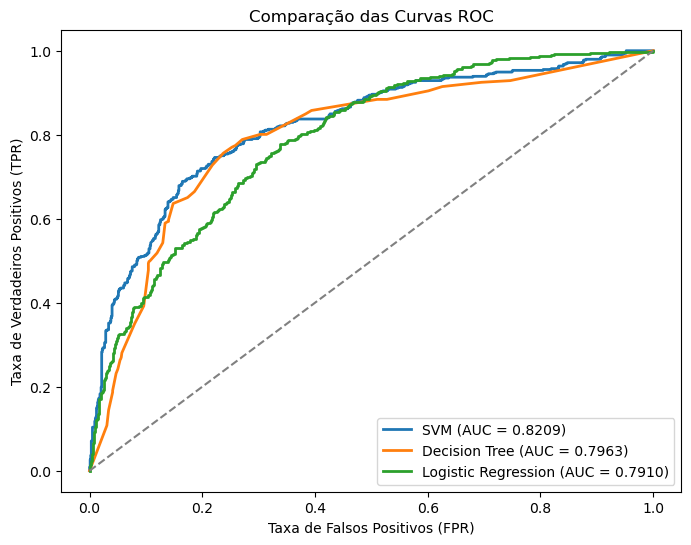

In [20]:
compare_roc_curves(
    models=[search_svm, search_dt_categ, search_reglog],  # GridSearchCV dos modelos
    model_names=['SVM', 'Decision Tree', 'Logistic Regression'],
    x_test=x_test,
    y_test=y_test
)

5 - Com base na Curva ROC, AUC e os outros medidores estatísticos, podemos eleger a regressão logistica com o de melhor desempenho. Contúdo, isso pode não refletir a realidade do negócio, necessáriamente. Seria necessário avaliar marcadores e dados do negócio para verificar a equalização dos modelos vizando o lucro ou o resultado ideal para o negócio.
Para tentar elucidar isso, criarei uma função para calcular um prejuizo, caso o Vinho seja classificado de maneira equivocada.

Caso ele classifique um vinho 0 porém ele era 1 = -200.00 pontos ( FALSE NEGATIVE) 
caso ele classifique um vinho 1 sendo 1 = 50 pontos (TRUE POSITIVE )
caso ele classifique um vinho como 1 sendo 0 = -100 pontos ( não queremos cobrar mais caro por um vinho inferior.) (FALSE POSITIVE)
caso ele classifique um vinho como 0 e de fato é 0 = 50 pontos(TRUE, NEGATIVE)

6 - Com a escolha do melhor modelo, use os dados de vinho tinto, presentes na base original e faça a inferência (não é para treinar novamente!!!) para saber quantos vinhos são bons ou ruins. Utilize o mesmo critério utilizado com os vinhos brancos, para comparar o desempenho do modelo. Ele funciona da mesma forma para essa nova base? Justifique.

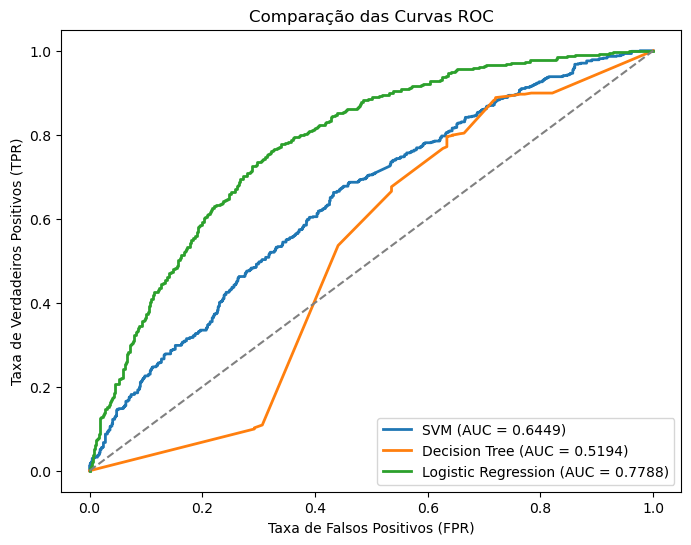

In [ ]:
#comparação dos modelos com a base de vinhos tintos
compare_roc_curves(
    models=[search_svm, search_dt_categ, search_reglog],  # GridSearchCV dos modelos
    model_names=['SVM', 'Decision Tree', 'Logistic Regression'],
    x_test=x_red,
    y_test=y_red
)

In [544]:
show_results_models(search_reglog, 0, x_red, 0, y_red, False)

Best params ==> {'model__C': 1, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.25, 'model__penalty': 'elasticnet'}
Best score: 0.6508236003409793
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.92      0.18      0.31       855
           1       0.51      0.98      0.67       744

    accuracy                           0.56      1599
   macro avg       0.72      0.58      0.49      1599
weighted avg       0.73      0.56      0.48      1599


Médias das métricas nos dados de TESTE:
Acurácia: 0.5560
Precisão: 0.7322
Recall: 0.5560
F1-Score: 0.4779


In [545]:
show_results_models(search_dt_categ, 0, x_red, 0, y_red, False)

Best params ==> {'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 5}
Best score: 0.6474750369613431
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.87      0.21      0.34       855
           1       0.52      0.96      0.67       744

    accuracy                           0.56      1599
   macro avg       0.69      0.59      0.51      1599
weighted avg       0.70      0.56      0.50      1599


Médias das métricas nos dados de TESTE:
Acurácia: 0.5622
Precisão: 0.7038
Recall: 0.5622
F1-Score: 0.4961
